<img align="centre" src="../../Supplementary_data/Github_banner.jpg" width="100%">

# Calculate the Enhanced Combined Drought Index

## Background 

Drought is an extended period, during which, fresh water availability and accessibility for the ecosystem at a given time and place is below normal, due to unfavourable spatial and temporal distribution of rainfall, temperature, soil moisture and wind characteristics [(Balint et al., 2013)](https://doi.org/10.1016/B978-0-444-59559-1.00023-2). Severe droughts can affect large populations, leading to a long-term threat to people’s livelihoods and result in tremendous economic loss [(Enenkel et al., 2016)](https://doi.org/10.3390/rs8040340).

The Enhanced Combined Drought(ECDI) Index aims at the timely and reliable detection of drought events with regard to their spatio-temporal extent and severity. The Enhanced Drought Index is a combination of the following:

- **Vegetation** component which considers NDVI deficits and deficit persistence. The index based on the vegetation component is named as **Vegetation Drought Index (VDI)**.
- **Precipitation** component, which considers rainfall deficits and dryness persistence. The index calculated using the precipitation component is referred as the  **Precipitation Drought Index (PDI)**.
- **Temperature** component, which considers temperature excesses and persistence of high temperatures. The index based on temperature is named as **Temperature Drought Index (TDI)**.
- **Soil moisture** component, which considers soil moisture deficits and deficit persistence. The index based on soil moisture is named as the **Soil Moisture Drought Index (SMDI)**.

The index uses **satellite-derived** rainfall, soil moisture, land surface temperature, and vegetation status as input datasets [(Enenkel et al., 2016)](https://doi.org/10.3390/rs8040340)


The notebook outlines:

***
1. Loading Python and DE Africa Packages
2. Load drought indices data
3. Calculate the weight for each drought index
4. Calculate the Enhanced Combined Drought Index
5. Drought Risk Warning Levels.
7. Calculate the Soil Moisture Drought Index
8. Export the result as zip

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
import json
import os
from datetime import datetime

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from deafrica_tools.spatial import add_geobox
from dekad import get_correlation, get_max_value
from odc.geo.geom import Geometry
from odc.geo.xr import rasterize
from pyarrow.parquet import read_table

### Define Area of Interest

In [2]:
#loading the countries shapefiles
african_countries_url = "https://raw.githubusercontent.com/digitalearthafrica/deafrica-sandbox-notebooks/main/Supplementary_data/Rainfall_anomaly_CHIRPS/african_countries.geojson"
african_countries = gpd.read_file(african_countries_url)
print(np.unique(african_countries.COUNTRY))

['Algeria' 'Angola' 'Benin' 'Botswana' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Cape Verde' 'Central African Republic' 'Chad' 'Comoros'
 'Congo-Brazzaville' 'Cote d`Ivoire' 'Democratic Republic of Congo'
 'Djibouti' 'Egypt' 'Equatorial Guinea' 'Eritrea' 'Ethiopia' 'Gabon'
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Kenya' 'Lesotho' 'Liberia'
 'Libya' 'Madagascar' 'Malawi' 'Mali' 'Mauritania' 'Morocco' 'Mozambique'
 'Namibia' 'Niger' 'Nigeria' 'Rwanda' 'Sao Tome and Principe' 'Senegal'
 'Sierra Leone' 'Somalia' 'South Africa' 'Sudan' 'Swaziland' 'Tanzania'
 'Togo' 'Tunisia' 'Uganda' 'Western Sahara' 'Zambia' 'Zimbabwe']


In [3]:
# Select the country of interest by providing the name below
country = "Ethiopia"
idx = african_countries[african_countries['COUNTRY'] == country].index[0]
geopolygon = Geometry(geom=african_countries.iloc[idx].geometry, crs=african_countries.crs)

### Load the drought indices data

In [4]:
PARQUET_META_KEY = b"xarray.metadata"
output_dir = "results"

### Load the results of Vegetation Drought Index (VDI) 

In [5]:
VDI_path = os.path.join(output_dir, f"VDI_{country}.parquet")

VDI_df = read_table(VDI_path)
attrs = json.loads(VDI_df.schema.metadata[PARQUET_META_KEY])

VDI_df = VDI_df.to_pandas()
VDI_df.attrs = attrs

VDI = VDI_df.to_xarray()
VDI = add_geobox(VDI, crs=VDI_df.attrs["crs"])
VDI

<xarray.Dataset> Size: 273MB
Dimensions:      (dekad: 404, y: 291, x: 290)
Coordinates:
  * dekad        (dekad) datetime64[ns] 3kB 2014-01-01 2014-01-11 ... 2025-03-11
  * y            (y) float64 2kB 4.325e+05 4.375e+05 ... 1.878e+06 1.882e+06
  * x            (x) float64 2kB 3.182e+06 3.188e+06 ... 4.622e+06 4.628e+06
    spatial_ref  int32 4B 6933
Data variables:
    NDVI         (dekad, y, x) float64 273MB nan nan nan nan ... nan nan nan nan

### Load the results of Soil Moisture Drought Index (SMDI)

In [6]:
SMDI_path = os.path.join(output_dir, f"SMDI_{country}.parquet")

SMDI_df = read_table(SMDI_path)
attrs = json.loads(SMDI_df.schema.metadata[PARQUET_META_KEY])

SMDI_df = SMDI_df.to_pandas()
SMDI_df.attrs = attrs

SMDI = SMDI_df.to_xarray()
SMDI = add_geobox(SMDI, crs=SMDI_df.attrs["crs"])

SMDI = SMDI.reindex_like(VDI)

# Ensure the timeseries matches the vegetation timeseries.
SMDI

<xarray.Dataset> Size: 273MB
Dimensions:                 (dekad: 404, y: 291, x: 290)
Coordinates:
  * dekad                   (dekad) datetime64[ns] 3kB 2014-01-01 ... 2025-03-11
  * y                       (y) float64 2kB 4.325e+05 4.375e+05 ... 1.882e+06
  * x                       (x) float64 2kB 3.182e+06 3.188e+06 ... 4.628e+06
    spatial_ref             int32 4B 6933
Data variables:
    relative_soil_moisture  (dekad, y, x) float64 273MB nan nan nan ... nan nan

### Load the results of  Temperature Drought Index (TDI)

In [7]:
TDI_path = os.path.join(output_dir, f"TDI_{country}.parquet")

TDI_df = read_table(TDI_path)
attrs = json.loads(TDI_df.schema.metadata[PARQUET_META_KEY])

TDI_df = TDI_df.to_pandas()
TDI_df.attrs = attrs

TDI = TDI_df.to_xarray()
TDI = add_geobox(TDI, crs=TDI_df.attrs["crs"])

# Ensure the timeseries matches the vegetation timeseries.
TDI = TDI.reindex_like(VDI)

TDI

<xarray.Dataset> Size: 273MB
Dimensions:              (dekad: 404, y: 291, x: 290)
Coordinates:
  * dekad                (dekad) datetime64[ns] 3kB 2014-01-01 ... 2025-03-11
  * y                    (y) float64 2kB 4.325e+05 4.375e+05 ... 1.882e+06
  * x                    (x) float64 2kB 3.182e+06 3.188e+06 ... 4.628e+06
    spatial_ref          int32 4B 6933
Data variables:
    surface_temperature  (dekad, y, x) float64 273MB nan nan nan ... nan nan nan

### Load the results of Precipitation Drought Index (PDI)

In [8]:
PDI_path = os.path.join(output_dir, f"PDI_{country}.parquet")

PDI_df = read_table(PDI_path)
attrs = json.loads(PDI_df.schema.metadata[PARQUET_META_KEY])

PDI_df = PDI_df.to_pandas()
PDI_df.attrs = attrs

PDI = PDI_df.to_xarray()
PDI = add_geobox(PDI, crs=PDI_df.attrs["crs"])

# Ensure the timeseries matches the vegetation timeseries.
PDI = PDI.reindex_like(VDI)

PDI

<xarray.Dataset> Size: 273MB
Dimensions:      (dekad: 404, y: 291, x: 290)
Coordinates:
  * dekad        (dekad) datetime64[ns] 3kB 2014-01-01 2014-01-11 ... 2025-03-11
  * y            (y) float64 2kB 4.325e+05 4.375e+05 ... 1.878e+06 1.882e+06
  * x            (x) float64 2kB 3.182e+06 3.188e+06 ... 4.622e+06 4.628e+06
    spatial_ref  int32 4B 6933
Data variables:
    rainfall     (dekad, y, x) float64 273MB nan nan nan nan ... nan nan nan nan

In [9]:
# If any index is missing data, set to None e.g.
# drought_indices = dict(rainfall=PDI.rainfall, temperature=TDI.surface_temperature, soil_moisture=None, vegetation=VDI.NDVI)
drought_indices = dict(rainfall=PDI.rainfall, temperature=TDI.surface_temperature, soil_moisture=SMDI.relative_soil_moisture, vegetation=VDI.NDVI)

### Calculate the weight for each drought index

The weight $w$ of each individual drought index is automatically calculated for every grid point (pixel) with respect to its capability to reflect the future vegetation status (NDVI). In the case of data gaps in one input dataset, the weights are automatically redistributed to other available variables.

\begin{equation}
w_{i} = \frac{\frac{lag^*_{i}}{\sum_{j=1}^{n} lag^*_{j}} + \frac{corr^*_{i}}{\sum_{j=1}^{n} corr^*_{j}}}{2}
\end{equation}

- $w$ weight for the respective drought index 

- $lag^*$ modified time lag for the respective parameter 

- $corr^*$ modified correlation coefficient for the respective parameter 

- $i$ index for the respective parameter/drought index 

- $j$ running parameter covering all parameters used for the ECDI calculation

- $n$ number of individual drought indices used for the ECDI calculation

In [10]:
correlation = {}
lag = {}
for k in drought_indices.keys():
    if drought_indices[k] is not None:
        calc_corr = get_correlation(reference_drought_index=VDI.NDVI, comparison_drought_index=drought_indices[k])
        correlation[k] = calc_corr["corr"]
        lag[k] = calc_corr["lag"]

In [11]:
weights = {}
for i in drought_indices.keys():
    if drought_indices[i] is not None:
         weights[i]=((lag[i]/np.nansum([i.values for i in lag.values()], axis=0) + (correlation[i]/np.nansum([i.values for i in correlation.values()], axis=0))))/2

### Calculate the Enhanced Combined Drought Index

The weight of every individual index is multiplied by the respective individual index to calculate the ECDI. The sum of all weights per decade is one.

\begin{equation}
ECDI = \sum_{i-1}^{n}w_{i} * \text{DI}_{i}
\end{equation}

- $ECDI$ Enhanced Combined Drought Index 

- $w$ Weight for each individual drought index (e.g., rainfall)

- $\text{DI}$ Individual drought index 

- $n$ number of drought indices used to calculate the ECDI 

- $i$ running parameter covering the number of drought indices

In [12]:
ECDI_np = np.nansum([weights[i]*drought_indices[i] for i in weights.keys()], axis=0)

In [13]:
# Convert NumPy array to xarray DataArray
ECDI = xr.DataArray(
    ECDI_np,
    dims=("y", "x", "dekad"),  # Use the same dimension names
    coords={dim: VDI.coords[dim] for dim in VDI["NDVI"].dims},  # Use the same coordinates
)
ECDI = add_geobox(ECDI, VDI.odc.geobox.crs)

In [14]:
# Rasterize the country geopolygon and mask the data.
country_mask = rasterize(poly=geopolygon, how=ECDI.odc.geobox)
ECDI = ECDI.where(country_mask)

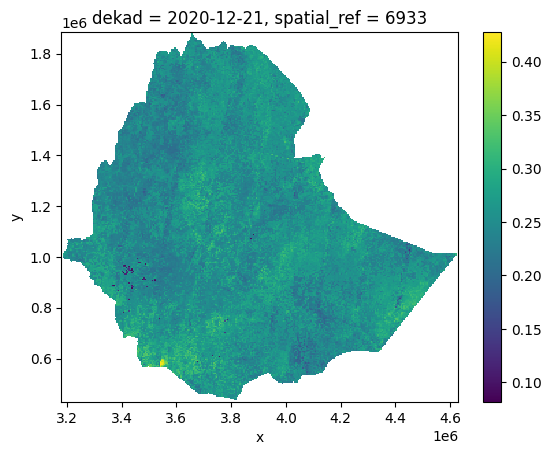

In [15]:
# Plot the most recent dekad
ECDI.sel(dekad="2020-12-21").plot()

### Drought Risk Warning Levels.

The ECDI-based drought risk warning levels (WL) are calculated as follows:

\begin{equation}
\text{Warning Levels}= \frac{\text{Current decadal ECDI value} - \text{Average ECDI value per decade}}{\text{Standard deviation of the decadal ECDI value}}
\end{equation}

In [16]:
# Select the dekad to calculate the warning levels for
selected_dekad = "2020-12-21"

# Select the timeseries upto the specific dekad
selected_ECDI = ECDI.sel(dekad=slice(None, selected_dekad))
selected_ECDI

<xarray.DataArray (y: 291, x: 290, dekad: 252)> Size: 170MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * dekad        (dekad) datetime64[ns] 2kB 2014-01-01 2014-01-11 ... 2020-12-21
  * y            (y) float64 2kB 4.325e+05 4.375e+05 ... 1.878e+06 1.882e+06
  * x            (x) float64 2kB 3.182e+06 3.188e+06 ... 4.622e+06 4.628e+06
    spatial_ref  int32 4B 6933

In [17]:
selected_dekad_month = datetime.strptime(selected_dekad, "%Y-%m-%d").month
selected_dekad_day = datetime.strptime(selected_dekad, "%Y-%m-%d").day

# Get the average ECDI value for the selected dekad 
avg_ECDI = selected_ECDI.sel(dekad=(selected_ECDI.dekad.dt.month == selected_dekad_month) & (selected_ECDI.dekad.dt.day == selected_dekad_day)).mean(dim="dekad")
# Get the standard deviation ECDI value for the selected dekad 
std_ECDI = selected_ECDI.sel(dekad=(selected_ECDI.dekad.dt.month == selected_dekad_month) & (selected_ECDI.dekad.dt.day == selected_dekad_day)).std(dim="dekad")

In [18]:
warning_levels = (selected_ECDI.sel(dekad=selected_dekad) - avg_ECDI)/ std_ECDI
warning_levels

<xarray.DataArray (y: 291, x: 290)> Size: 675kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    dekad        datetime64[ns] 8B 2020-12-21
  * y            (y) float64 2kB 4.325e+05 4.375e+05 ... 1.878e+06 1.882e+06
  * x            (x) float64 2kB 3.182e+06 3.188e+06 ... 4.622e+06 4.628e+06
    spatial_ref  int32 4B 6933

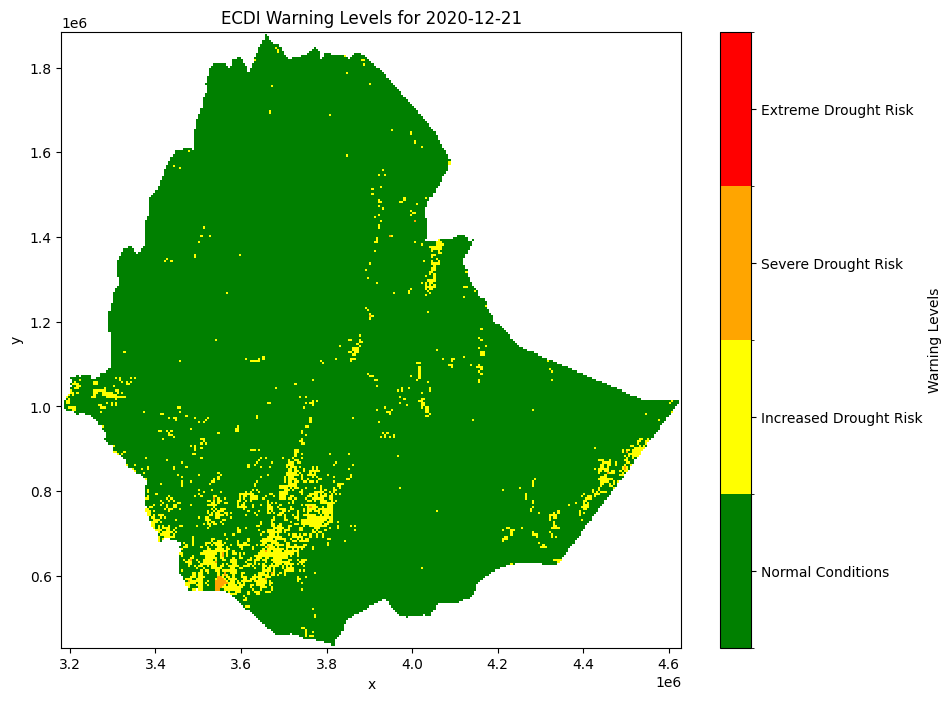

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green', 'yellow', 'orange', 'red']
cmap = mpl.colors.ListedColormap(colors)
sel
bounds = [-10, 0.5, 1.5, 2.5, 10]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

im = warning_levels.plot(cmap=cmap, norm=norm, add_colorbar=False)

ticks = pd.Series(bounds).rolling(2).mean()[1:].to_list()
tick_labels = ["Normal Conditions", "Increased Drought Risk", "Severe Drought Risk", "Extreme Drought Risk"]
cbar = plt.colorbar(im, ax=ax, ticks=ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label("Warning Levels")

ax.set_title(f"ECDI Warning Levels for {selected_dekad}")
plt.savefig(f"results/{country}_ecdi_warning_levels_{selected_dekad}.png")

plt.show()

---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

<b> Compatible datacube version :</b>

In [20]:
import datacube
print(datacube.__version__)

1.8.20


**Last Tested:**

In [21]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-03-21'